# classifiers comparision

Comparison of the metrics obtained by the different pretrained models, and decision of the best.

In [1]:
__import__('sys').path.append('../scripts/common'); __import__('notebook_utils').table_of_contents('classifiers_comparison.ipynb')

<h3>Table of contents</h3>


[classifiers comparision](#classifiers-comparision)
- [Setup](#Setup)
- [Final models](#Final-models)
- [Final iteration](#Final-iteration)
  - [Plots](#Plots)
- [Previous iterations](#Previous-iterations)

## Setup

In [2]:
# IMPORTS
# Display
from IPython.display import display, HTML
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Basics
import numpy as np
import pandas as pd
import os
import json

## Custom functions
import sys
sys.path.append('../scripts/common')
from analysis_utils import prettify_plots
from notebook_utils import md, h4, h3
prettify_plots()

# Set pandas display option for floating-point numbers
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
# DEFINE VARIABLES
metrics = ['accuracy', 'f1_score', 'recall', 'precision']
MODELS_FOLDER = '../classifiers_training/saved_models/'

In [ ]:
# FUNCTIONS
def load_params(file_path):
    with open(file_path) as json_file:
        return json.load(json_file)

def get_meaned_comparison_df(models_path, models_list, TRI = None, MoR = None):
    
    # Get the type of classifier from the models_path
    if TRI is None:
        TRI = 'TRI' in models_path
    if MoR is None:
        MoR = 'MoR' in models_path

    def process_metrics(report_df):
        metrics_df = report_df.drop(columns=['confusion', 'fold', 'probabilities', 'labels', 'val_texts'])  

        if TRI:
            # Average all columns
            metrics_mean = metrics_df.mean().to_frame().T
            metrics_std = metrics_df.std().add_suffix('_std').to_frame().T
            metrics_df = pd.concat([metrics_mean, metrics_std], axis=1)

        elif MoR:
            # Get the mean of the 5 folds per label, with 'decs' decimals
            decs = 2
            metrics_mean = metrics_df.apply(lambda x: [np.mean(np.stack(x), axis=0)] , axis=0)
            metrics_mean = metrics_mean.map(lambda x: [round(num, decs) for num in x]) 

            # Get the std of the 5 folds per label, using ceil with 'decs' decimals
            metrics_std = metrics_df.apply(lambda x: [np.std(np.stack(x), axis=0)] , axis=0).add_suffix('_std')
            metrics_std = metrics_std.map(lambda x: [round(np.ceil(num*10**decs)*10**-decs, decs) for num in x]) 
            
            metrics_df = pd.concat([metrics_mean, metrics_std], axis=1) 
            
            # Average the metrics per label, leaving 1 value 
            metrics_mean_mean = metrics_mean.map(lambda x: np.mean(x)).add_suffix('_mean')
            metrics_df = pd.concat([metrics_df, metrics_mean_mean], axis=1) 
            
        else:
            print('Sth went wrong')
        return metrics_df

    def process_confusion_matrices(report_df):
        confusion = report_df[['confusion']].apply(lambda x: [np.sum(np.stack(x), axis=0)] , axis=0)
        return confusion
            
    dfs = []
    for model_name in models_list:
        params = load_params(os.path.join(models_path, model_name, "train_params.json"))
        
        # Convert report_df to DataFrame and process
        report_df = pd.DataFrame(params['report_df'])

        # Average / sum metrics
        confusion = process_confusion_matrices(report_df)
        metrics = process_metrics(report_df)
        metrics = metrics.join(confusion)
        
        # Add model information
        metrics['pretrained_model'] = params['pretrained_model']
        metrics['weights'] = '_'.join(map(str, params['train_loss_weights']))
        metrics['model_name'] = model_name
        metrics['num_epochs'] = params['num_epochs']
        for preds in ['probabilities', 'labels', 'val_texts']:
            metrics[preds] = report_df[preds]

        dfs.append(metrics)
        
    return pd.concat(dfs, ignore_index=True)

def highlight_max_num(col):
    '''Highlight the max number per column'''
    col = round(col, 2)
    max_num = max(col)
    col = col.replace(max_num, f'<b>{max_num}</b>')
    return col

def plot_evaluation_parameters(ax, df, title, legend=True):
    '''
    df: DataFrame with ['model_name']
    '''
    if 'model_name' not in df.columns:
        raise ValueError("DataFrame must have column 'model_name'")
    # Get the relevant columns
    
    # Melt the DataFrame to make it long-form
    df_melted = df.melt(id_vars='model_name', var_name='metric', value_name='score')
    
    # Plot each metric for each model
    for model_name in df['model_name'].unique():
        subset = df_melted[df_melted['model_name'] == model_name]
        ax.plot(subset['metric'], subset['score'], marker='o', label=model_name)
    
    # Add labels and title
    ax.set_title(title)
    ax.set_ylabel('Score')
    if legend:
        ax.legend()

## Final models

In [1]:
# FINAL MODELS (evaluated on test data)
folder = MODELS_FOLDER + f'final_models/'
models_names = os.listdir(folder)

# Extract metrics from train_params.json
df1 = get_meaned_comparison_df(folder, models_names[:1], MoR=True)
df2 = get_meaned_comparison_df(folder, models_names[1:], TRI=True)
df = pd.concat([df1, df2], ignore_index=True)

columns = ['model_name'] + [m+'_mean' for m in metrics] + metrics
display(df[columns])

,model_name,accuracy_mean,f1_score_mean,recall_mean,precision_mean,accuracy,f1_score,recall,precision
0,MoR_final_BioLinkBERT_5e_lr3e-05,0.94,0.94,0.94,0.94,"[0.89, 0.97, 0.97]","[0.93, 0.95, 0.94]","[0.89, 0.97, 0.97]","[0.97, 0.93, 0.91]"
1,TRI_final_BioLinkBERT_5e_lr3e-05,NaN,NaN,NaN,NaN,0.95,0.95,0.96,0.95


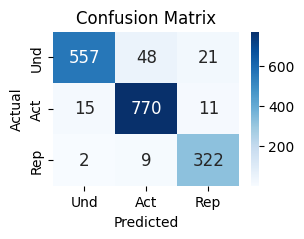

In [24]:
# Show confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["Und", "Act", "Rep"]
conf_matrix = pd.DataFrame(df["confusion"][0], index=labels, columns=labels)

plt.figure(figsize=(3,2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Final iteration

In [6]:
# FINAL ITERATION (evaluated through cross-validation)
for XXX in ['TRI', 'MoR']:
    
    h4(XXX)

    folder = MODELS_FOLDER + f'{XXX}_classifier/'
    models_names = os.listdir(folder)

    # Remove the folders containing the runs before the 1st, 2nd and 3rd validation iterations
    models_names = [m for m in models_names if m not in [f'before_{i}_validation' for i in ['1st', '2nd', '3rd']]]

    # Extract metrics from train_params.json
    df = get_meaned_comparison_df(folder, models_names).sort_values(by='f1_score', ascending=False)

    # Display the model with the highest f1 score
    df[metrics] = df[metrics].apply(lambda x: highlight_max_num(x))

    # Determine columns to display
    columns = ['model_name'] + ([m+'_mean' for m in metrics] if XXX == 'MoR' else []) + metrics + [m+'_std' for m in metrics]

    display(HTML(df[columns].set_index('model_name').to_html(escape=False)))

<h4>TRI</h4>

,accuracy,f1_score,recall,precision,accuracy_std,f1_score_std,recall_std,precision_std
model_name,,,,,,,,
BioLinkBERT_span_8e_lr3e-05,0.94,0.95,0.97,0.92,0.01,0.01,0.01,0.01
BioLinkBERT_span_5e_lr3e-05,0.94,0.95,0.96,0.93,0.00,0.00,0.02,0.02
BiomedNLP_span_5e_lr3e-05,0.94,0.94,0.96,0.93,0.00,0.00,0.01,0.01
BiomedNLP-large_5e_lr3e-05,0.94,0.94,0.96,0.93,0.01,0.01,0.01,0.02
BiomedNLP_5e_lr3e-05,0.94,0.94,0.96,0.92,0.01,0.01,0.01,0.01
BioLinkBERT_5e_lr3e-05,0.94,0.94,0.95,0.94,0.00,0.00,0.01,0.01
sciBERT_span_5e_lr3e-05,0.94,0.94,0.96,0.92,0.01,0.01,0.01,0.01
BioLinkBERT_span_10e_lr3e-05,0.93,0.94,0.98,0.90,0.01,0.01,0.01,0.02
sciBERT_5e_lr3e-05,0.93,0.94,0.95,0.92,0.01,0.01,0.02,0.01


<h4>MoR</h4>

,accuracy_mean,f1_score_mean,recall_mean,precision_mean,accuracy,f1_score,recall,precision,accuracy_std,f1_score_std,recall_std,precision_std
model_name,,,,,,,,,,,,
BioLinkBERT_span_8e_lr3e-05,0.94,0.93,0.94,0.93,"[0.92, 0.94, 0.95]","[0.93, 0.94, 0.92]","[0.92, 0.94, 0.95]","[0.94, 0.95, 0.89]","[0.02, 0.01, 0.01]","[0.01, 0.01, 0.02]","[0.02, 0.01, 0.01]","[0.02, 0.02, 0.03]"
BioLinkBERT_span_5e_lr3e-05,0.93,0.93,0.93,0.93,"[0.9, 0.95, 0.94]","[0.93, 0.94, 0.92]","[0.9, 0.95, 0.94]","[0.95, 0.93, 0.9]","[0.02, 0.02, 0.02]","[0.01, 0.01, 0.02]","[0.02, 0.02, 0.02]","[0.02, 0.02, 0.04]"
BiomedNLP_5e_lr3e-05,0.92,0.92,0.92,0.92,"[0.9, 0.95, 0.92]","[0.93, 0.94, 0.9]","[0.9, 0.95, 0.92]","[0.95, 0.93, 0.88]","[0.02, 0.01, 0.02]","[0.01, 0.01, 0.01]","[0.02, 0.01, 0.02]","[0.01, 0.01, 0.02]"
BioLinkBERT_span_10e_lr3e-05,0.92,0.92,0.92,0.92,"[0.88, 0.95, 0.94]","[0.92, 0.94, 0.91]","[0.88, 0.95, 0.94]","[0.96, 0.92, 0.88]","[0.02, 0.01, 0.03]","[0.01, 0.02, 0.02]","[0.02, 0.01, 0.03]","[0.02, 0.03, 0.02]"
BioLinkBERT_5e_lr3e-05,0.93,0.92,0.93,0.92,"[0.91, 0.94, 0.93]","[0.92, 0.94, 0.91]","[0.91, 0.94, 0.93]","[0.94, 0.94, 0.88]","[0.02, 0.02, 0.02]","[0.01, 0.01, 0.02]","[0.02, 0.02, 0.02]","[0.02, 0.02, 0.04]"
BioLinkBERT_8e_lr3e-05,0.92,0.92,0.92,0.92,"[0.88, 0.96, 0.93]","[0.92, 0.94, 0.91]","[0.88, 0.96, 0.93]","[0.95, 0.92, 0.89]","[0.03, 0.02, 0.03]","[0.01, 0.01, 0.02]","[0.03, 0.02, 0.03]","[0.02, 0.03, 0.02]"
BiomedNLP_span_5e_lr3e-05,0.93,0.92,0.93,0.93,"[0.91, 0.95, 0.92]","[0.92, 0.94, 0.91]","[0.91, 0.95, 0.92]","[0.94, 0.93, 0.91]","[0.02, 0.02, 0.03]","[0.01, 0.01, 0.01]","[0.02, 0.02, 0.03]","[0.03, 0.02, 0.04]"
BiomedNLP-large_5e_lr3e-05,0.93,0.92,0.93,0.93,"[0.9, 0.95, 0.93]","[0.92, 0.94, 0.91]","[0.9, 0.95, 0.93]","[0.95, 0.93, 0.9]","[0.03, 0.02, 0.03]","[0.02, 0.01, 0.02]","[0.03, 0.02, 0.03]","[0.01, 0.02, 0.04]"
BiomedNLP-large_span_5e_lr3e-05,0.92,0.92,0.92,0.93,"[0.89, 0.95, 0.93]","[0.92, 0.94, 0.91]","[0.89, 0.95, 0.93]","[0.95, 0.93, 0.9]","[0.04, 0.02, 0.03]","[0.01, 0.01, 0.02]","[0.04, 0.02, 0.03]","[0.03, 0.03, 0.04]"


### Plots

<h3>TRI</h3>

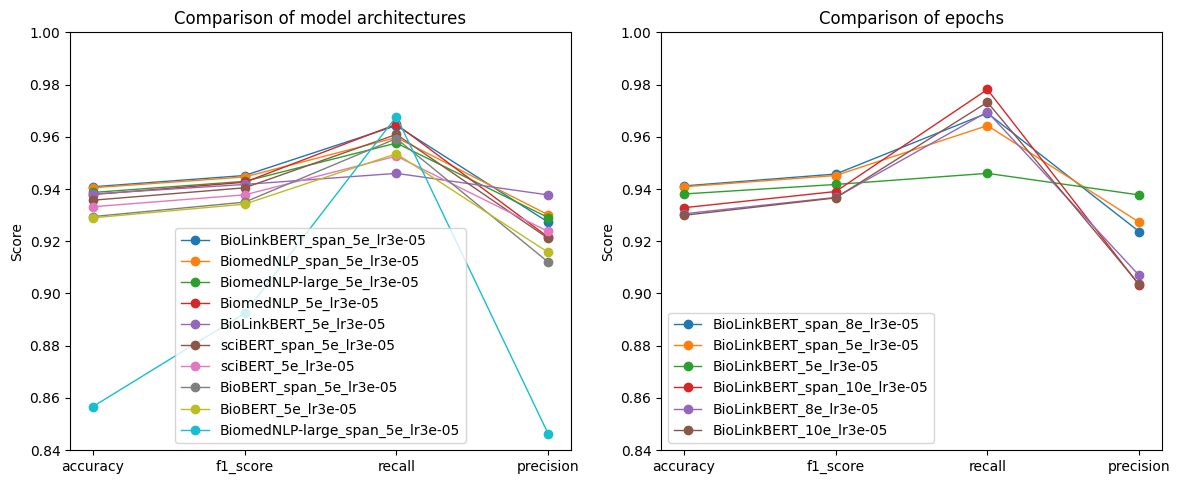

In [ ]:
# TRI
TRI_folder = MODELS_FOLDER + 'TRI_classifier/'
TRI_models_names = os.listdir(TRI_folder)
TRI_models_names = [m for m in TRI_models_names if m not in [f'before_{i}_validation' for i in ['1st', '2nd', '3rd']]]
TRI_df = get_meaned_comparison_df(TRI_folder, TRI_models_names).sort_values(by='f1_score', ascending=False)

h3('TRI')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
display(HTML('<h4>Comparison of evaluation parameters</h4>'))

for ax, df, title in [[ax1, TRI_df[TRI_df['num_epochs'] == 5], "Comparison of model architectures"], 
                      [ax2, TRI_df[TRI_df['pretrained_model'] == 'BioLinkBERT'], "Comparison of epochs"]]:
    df_metrics = df[['model_name'] + metrics]
    plot_evaluation_parameters(ax, df_metrics, title)
    ax.set_ylim(0.84, 1)
plt.tight_layout()    
plt.show()

<h3>MoR</h3>

<h4>Comparison of evaluation parameters per label</h4>

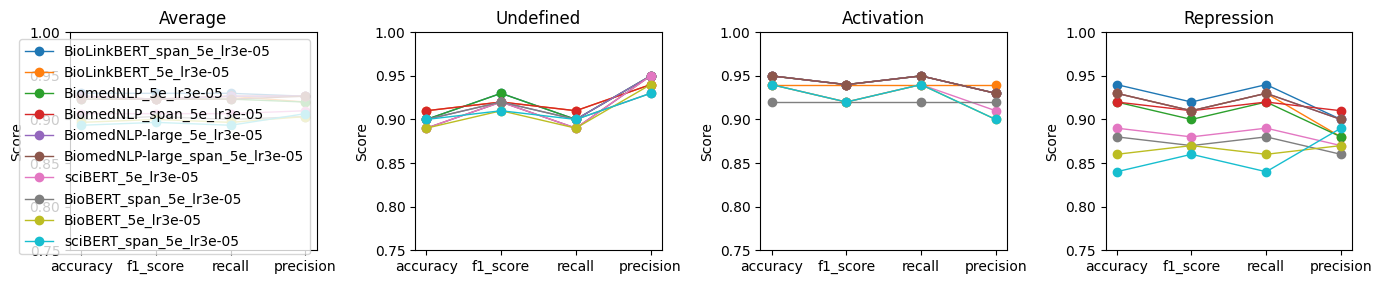

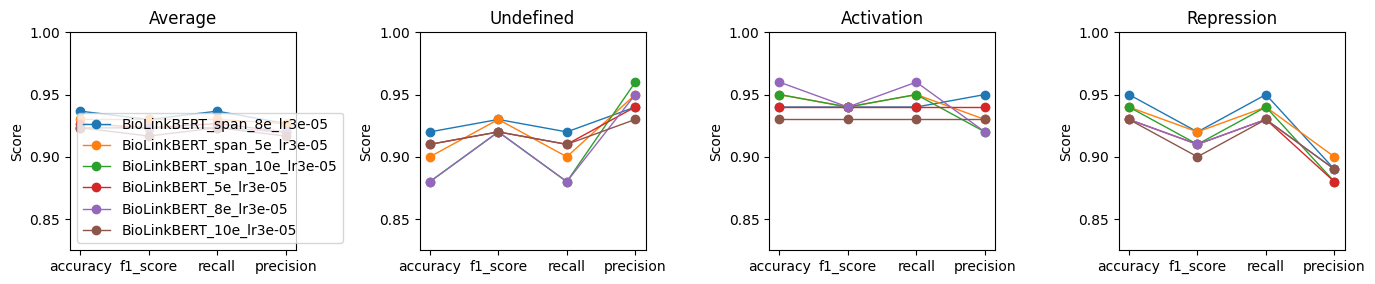

In [8]:
h3('MoR')

MoR_columns = ['model_name'] + [m+'_mean' for m in metrics] + metrics + [m+'_std' for m in metrics]
MoR_folder = MODELS_FOLDER + 'MoR_classifier/'
MoR_models = os.listdir(MoR_folder)
MoR_models = [m for m in MoR_models if m not in [f'before_{i}_validation' for i in ['1st', '2nd', '3rd']]]
MoR_df = get_meaned_comparison_df(MoR_folder, MoR_models).sort_values(by='f1_score_mean', ascending=False)

h4('Comparison of evaluation parameters per label')
# Plot different subsets of the data
for mask, heading, min_ylim in [[MoR_df['num_epochs'] == 5, 'On different architectures', 0.75],
                                [MoR_df['pretrained_model'] == 'BioLinkBERT', 'On different number of epochs', 0.825]]:
    MoR_df_subset = MoR_df[mask]
    MoR_df_subset.set_index('model_name', inplace=True)
    labels = ['Undefined', 'Activation', 'Repression']
    fig, axs = plt.subplots(1, 4, figsize=(14, 3))
    display(HTML(f'<h4>{heading}</h4>'))

    # Plot over labels
    MoR_metrics = MoR_df_subset[[m+'_mean' for m in metrics]].reset_index()
    MoR_metrics.columns = [col.replace('_mean', '') for col in MoR_metrics.columns]
    plot_evaluation_parameters(axs[0], MoR_metrics, 'Average') 
    axs[0].set_ylim(min_ylim, 1)
    
    # Plot labels
    for i, title in enumerate(labels):
        MoR_label_metrics = MoR_df_subset[metrics].apply(lambda x: [y[i] for y in x]).reset_index()
        plot_evaluation_parameters(axs[i+1], MoR_label_metrics, title, legend=False)
        axs[i+1].set_ylim(min_ylim, 1)   
    plt.tight_layout()    
    plt.show()

In [9]:
# Display sentences with the more far off predictions
labels_names = {0: 'Undefined', 1: 'Activation', 2: 'Repression'}
pd.set_option('display.max_colwidth', 1000)

preds_list = ['probabilities', 'labels', 'val_texts']
preds_df = MoR_df[MoR_df['pretrained_model'] == 'BioLinkBERT'][preds_list].explode(preds_list)
preds_df['correct_prob'] = preds_df.apply(lambda row: row['probabilities'][row['labels']], axis=1)
preds_df['predicted'] = preds_df.apply(lambda row: np.argmax(row['probabilities']), axis=1)
preds_df['predicted'] = preds_df['predicted'].map(labels_names)
preds_df['correct'] = preds_df['labels'].map(labels_names)

preds_df = preds_df.sort_values('correct_prob')[['val_texts', 'correct_prob', 'correct', 'predicted']]
# display(preds_df[preds_df['correct_prob'] < 0.05])
display(preds_df[:20])

,val_texts,correct_prob,correct,predicted
0,The interference of <TF>PPARalpha</TF>/retinoid X receptor alpha with the AP-1 transcription factor elements c-Jun/c-Fos resulted in the inhibition of AP-1 binding and down-regulation of the <TG>VDUP-1</TG> gene expression.,0.00,Repression,Activation
7,"Furthermore, <TF>Twist-1</TF> inhibits the expression of the bHLH transcription factor E47, which is normally expressed in senescent MSCs and induces transcription of the <TG>p16</TG> promoter.",0.00,Repression,Activation
7,The interference of <TF>PPARalpha</TF>/retinoid X receptor alpha with the AP-1 transcription factor elements c-Jun/c-Fos resulted in the inhibition of AP-1 binding and down-regulation of the <TG>VDUP-1</TG> gene expression.,0.00,Repression,Activation
0,"Similarly, deletion of the <TF>Oct-1</TF> site reduced the induction of <TG>CRP</TG> expression in response to overexpressed C/EBP, and overexpressed Oct-1 inhibited C/EBP-induced CRP expression through the promoter lacking the Oct-1 site.",0.00,Repression,Activation
0,"The amount of <TF>Dmp1</TF> bound to the <TG>Arf</TG> promoter decreased significantly upon anthracyclin treatment; this, in turn, downregulated the Arf levels.",0.00,Activation,Undefined
4,"Conversely, PPARgamma1 ligand 15-deoxy Delta (12,14)-prostaglandin J2 dose-dependently suppressed the binding of [TG] promoter region with both [TF] and Sp3, resulting an inhibition of KDR gene expression.",0.00,Activation,Undefined
0,"Activation of the transcription factor <TF>HIF-1</TF> and its target genes, <TG>VEGF</TG>, HO-1, iNOS, during fracture repair.",0.00,Activation,Undefined
8,"Crucially, addition of the anti-estrogen [TF] caused a differential recruitment in vivo of ERalpha and ERbeta onto the hTERT promoter and inhibited [TG] activity.",0.00,Activation,Repression
7,Tip60 functions as a potential corepressor of <TF>KLF4</TF> in regulation of <TG>HDC</TG> promoter activity.,0.00,Repression,Undefined
4,"The amount of [TF] bound to the [TG] promoter decreased significantly upon anthracyclin treatment; this, in turn, downregulated the Arf levels.",0.00,Activation,Undefined


## Previous iterations

Best models for the past iterations, used to improve the model (top 3 models per iteration)

In [ ]:
for XXX in ['TRI', 'MoR']:
    h4(XXX)

    for i in ['1st', '2nd', '3rd']:
        md(f"before {i} iteration")

        folder = MODELS_FOLDER + f'{XXX}_classifier/before_{i}_validation'
        models_names = os.listdir(folder)

        # Extract metrics from train_params.json
        df = get_meaned_comparison_df(folder, models_names).sort_values(by='f1_score', ascending=False).sort_values(by='num_epochs')

        # Display the model with the highest f1 score
        df[metrics] = df[metrics].apply(lambda x: highlight_max_num(x))

        # Determine columns to display
        columns = ['model_name', 'num_epochs'] + ([m+'_mean' for m in metrics] if XXX == 'MoR' else []) + metrics + [m+'_std' for m in metrics]

        display(HTML(df[columns].set_index('model_name').to_html(escape=False)))

<h4>TRI</h4>

before 1st iteration

,num_epochs,accuracy,f1_score,recall,precision,accuracy_std,f1_score_std,recall_std,precision_std
model_name,,,,,,,,,
BioLinkBERT_2e,2,0.89,0.90,0.96,0.85,0.00,0.00,0.01,0.01
BioLinkBERT,3,0.9,0.91,0.94,0.87,0.00,0.00,0.02,0.01
BiomedNLP,3,0.9,0.90,0.95,0.86,0.01,0.01,0.02,0.01
sciBERT,3,0.89,0.90,0.93,0.87,0.00,0.00,0.02,0.01
BioBERT,3,0.88,0.89,0.93,0.86,0.00,0.00,0.02,0.01
BioLinkBERT_4e,4,0.9,0.90,0.95,0.86,0.00,0.00,0.01,0.02
BioLinkBERT_5e_lr3e-05,5,0.9,0.91,0.94,0.87,0.00,0.00,0.03,0.03
BioLinkBERT_5e_old_data,5,0.9,0.91,0.95,0.87,0.01,0.01,0.02,0.01
BioLinkBERT_5e_lr1e-06,5,0.88,0.89,0.96,0.83,0.01,0.01,0.00,0.01


before 2nd iteration

,num_epochs,accuracy,f1_score,recall,precision,accuracy_std,f1_score_std,recall_std,precision_std
model_name,,,,,,,,,
BioLinkBERT_span_lr3e-05,3,0.92,0.93,0.96,0.9,0.00,0.00,0.02,0.01
BioLinkBERT_lr3e-05,3,0.92,0.92,0.95,0.89,0.01,0.01,0.02,0.01
BioLinkBERT_span_5e_lr3e-05,5,0.93,0.93,0.97,0.9,0.01,0.01,0.00,0.01
BioLinkBERT_5e_lr3e-05,5,0.92,0.92,0.96,0.89,0.01,0.01,0.01,0.02


before 3rd iteration

,num_epochs,accuracy,f1_score,recall,precision,accuracy_std,f1_score_std,recall_std,precision_std
model_name,,,,,,,,,
BioLinkBERT_span_5e_lr3e-05,5,0.95,0.95,0.97,0.94,0.00,0.00,0.01,0.01
BioLinkBERT_1fold_5e_lr3e-05,5,0.95,0.95,0.96,0.94,NaN,NaN,NaN,NaN
BioLinkBERT_5e_lr3e-05,5,0.95,0.95,0.96,0.94,0.00,0.00,0.01,0.01
BioLinkBERT_span_1fold_5e_lr3e-05,5,0.94,0.95,0.96,0.93,NaN,NaN,NaN,NaN
BioLinkBERT_span_1fold_7e_lr3e-05,7,0.95,0.95,0.98,0.92,NaN,NaN,NaN,NaN
BioLinkBERT_1fold_7e_lr3e-05,7,0.94,0.95,0.95,0.95,NaN,NaN,NaN,NaN
BioLinkBERT_1fold_8e_lr3e-05,8,0.95,0.95,0.95,0.95,NaN,NaN,NaN,NaN
BioLinkBERT_span_1fold_8e_lr3e-05,8,0.94,0.94,0.93,0.96,NaN,NaN,NaN,NaN
BioLinkBERT_span_1fold_10e_lr3e-05,10,0.94,0.95,0.97,0.93,NaN,NaN,NaN,NaN


<h4>MoR</h4>

before 1st iteration

,num_epochs,accuracy_mean,f1_score_mean,recall_mean,precision_mean,accuracy,f1_score,recall,precision,accuracy_std,f1_score_std,recall_std,precision_std
model_name,,,,,,,,,,,,,
BioLinkBERT_2e,2,0.88,0.88,0.88,0.87,"[0.86, 0.9, 0.88]","[0.87, 0.9, 0.87]","[0.86, 0.9, 0.88]","[0.88, 0.89, 0.85]","[0.03, 0.03, 0.05]","[0.01, 0.01, 0.02]","[0.03, 0.03, 0.05]","[0.03, 0.03, 0.03]"
BioLinkBERT,3,0.89,0.89,0.89,0.89,"[0.85, 0.92, 0.9]","[0.88, 0.91, 0.88]","[0.85, 0.92, 0.9]","[0.9, 0.9, 0.87]","[0.03, 0.03, 0.03]","[0.01, 0.01, 0.01]","[0.03, 0.03, 0.03]","[0.03, 0.02, 0.03]"
BiomedNLP,3,0.89,0.89,0.89,0.88,"[0.85, 0.91, 0.91]","[0.88, 0.9, 0.88]","[0.85, 0.91, 0.91]","[0.9, 0.9, 0.85]","[0.02, 0.02, 0.02]","[0.01, 0.01, 0.02]","[0.02, 0.02, 0.02]","[0.02, 0.02, 0.04]"
sciBERT,3,0.87,0.87,0.87,0.86,"[0.83, 0.9, 0.88]","[0.87, 0.89, 0.84]","[0.83, 0.9, 0.88]","[0.9, 0.88, 0.81]","[0.04, 0.03, 0.04]","[0.01, 0.02, 0.02]","[0.04, 0.03, 0.04]","[0.03, 0.02, 0.03]"
BioBERT,3,0.87,0.86,0.87,0.86,"[0.83, 0.88, 0.91]","[0.87, 0.88, 0.83]","[0.83, 0.88, 0.91]","[0.91, 0.89, 0.77]","[0.03, 0.03, 0.03]","[0.01, 0.01, 0.01]","[0.03, 0.03, 0.03]","[0.03, 0.01, 0.03]"
BioLinkBERT_4e,4,0.90,0.89,0.90,0.88,"[0.88, 0.89, 0.92]","[0.88, 0.91, 0.88]","[0.88, 0.89, 0.92]","[0.88, 0.92, 0.85]","[0.02, 0.03, 0.02]","[0.02, 0.02, 0.01]","[0.02, 0.03, 0.02]","[0.04, 0.02, 0.02]"
BioLinkBERT_5e_lr3e-05,5,0.90,0.90,0.90,0.90,"[0.86, 0.92, 0.93]","[0.88, 0.92, 0.89]","[0.86, 0.92, 0.93]","[0.91, 0.91, 0.87]","[0.03, 0.02, 0.02]","[0.01, 0.01, 0.03]","[0.03, 0.02, 0.02]","[0.02, 0.02, 0.05]"
BioLinkBERT_5e_old_data,5,0.90,0.90,0.90,0.89,"[0.86, 0.92, 0.92]","[0.88, 0.91, 0.9]","[0.86, 0.92, 0.92]","[0.9, 0.91, 0.87]","[0.01, 0.02, 0.02]","[0.01, 0.01, 0.02]","[0.01, 0.02, 0.02]","[0.02, 0.01, 0.02]"
BioLinkBERT_5e_lr1e-06,5,0.82,0.82,0.82,0.81,"[0.82, 0.83, 0.82]","[0.84, 0.85, 0.76]","[0.82, 0.83, 0.82]","[0.86, 0.86, 0.71]","[0.02, 0.03, 0.03]","[0.01, 0.02, 0.03]","[0.02, 0.03, 0.03]","[0.03, 0.01, 0.04]"


before 2nd iteration

,num_epochs,accuracy_mean,f1_score_mean,recall_mean,precision_mean,accuracy,f1_score,recall,precision,accuracy_std,f1_score_std,recall_std,precision_std
model_name,,,,,,,,,,,,,
BioLinkBERT_lr3e-05,3,0.92,0.91,0.92,0.91,"[0.89, 0.94, 0.92]","[0.91, 0.93, 0.9]","[0.89, 0.94, 0.92]","[0.94, 0.92, 0.88]","[0.04, 0.02, 0.02]","[0.01, 0.02, 0.02]","[0.04, 0.02, 0.02]","[0.03, 0.04, 0.02]"
BioLinkBERT_span_lr3e-05,3,0.92,0.91,0.92,0.92,"[0.9, 0.94, 0.91]","[0.91, 0.93, 0.9]","[0.9, 0.94, 0.91]","[0.94, 0.92, 0.9]","[0.03, 0.02, 0.05]","[0.01, 0.02, 0.03]","[0.03, 0.02, 0.05]","[0.02, 0.04, 0.03]"
BioLinkBERT_5e_lr3e-05,5,0.93,0.93,0.93,0.93,"[0.89, 0.95, 0.94]","[0.92, 0.94, 0.92]","[0.89, 0.95, 0.94]","[0.95, 0.93, 0.9]","[0.02, 0.02, 0.04]","[0.01, 0.01, 0.02]","[0.02, 0.02, 0.04]","[0.02, 0.02, 0.03]"


before 3rd iteration

,num_epochs,accuracy_mean,f1_score_mean,recall_mean,precision_mean,accuracy,f1_score,recall,precision,accuracy_std,f1_score_std,recall_std,precision_std
model_name,,,,,,,,,,,,,
BioLinkBERT_span_1fold_5e_lr3e-05,5,0.94,0.94,0.94,0.94,"[0.91, 0.96, 0.96]","[0.94, 0.95, 0.93]","[0.91, 0.96, 0.96]","[0.97, 0.94, 0.9]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
BioLinkBERT_span_5e_lr3e-05,5,0.93,0.93,0.93,0.93,"[0.9, 0.95, 0.95]","[0.93, 0.94, 0.91]","[0.9, 0.95, 0.95]","[0.96, 0.94, 0.89]","[0.02, 0.02, 0.03]","[0.02, 0.01, 0.02]","[0.02, 0.02, 0.03]","[0.02, 0.01, 0.04]"
BioLinkBERT_1fold_5e_lr3e-05,5,0.93,0.93,0.93,0.93,"[0.89, 0.96, 0.94]","[0.92, 0.94, 0.93]","[0.89, 0.96, 0.94]","[0.95, 0.93, 0.91]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
BioLinkBERT_5e_lr3e-05,5,0.93,0.92,0.93,0.92,"[0.89, 0.95, 0.94]","[0.92, 0.94, 0.91]","[0.89, 0.95, 0.94]","[0.95, 0.93, 0.89]","[0.02, 0.01, 0.03]","[0.01, 0.01, 0.01]","[0.02, 0.01, 0.03]","[0.02, 0.01, 0.02]"
BioLinkBERT_span_1fold_7e_lr3e-05,7,0.94,0.94,0.94,0.93,"[0.93, 0.94, 0.96]","[0.94, 0.95, 0.92]","[0.93, 0.94, 0.96]","[0.94, 0.96, 0.88]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
BioLinkBERT_1fold_7e_lr3e-05,7,0.91,0.89,0.91,0.88,"[0.94, 0.85, 0.93]","[0.9, 0.9, 0.86]","[0.94, 0.85, 0.93]","[0.87, 0.95, 0.81]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
BioLinkBERT_1fold_8e_lr3e-05,8,0.94,0.94,0.94,0.94,"[0.91, 0.96, 0.95]","[0.93, 0.95, 0.93]","[0.91, 0.96, 0.95]","[0.96, 0.94, 0.91]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
BioLinkBERT_span_1fold_8e_lr3e-05,8,0.93,0.93,0.93,0.92,"[0.92, 0.93, 0.95]","[0.92, 0.94, 0.92]","[0.92, 0.93, 0.95]","[0.93, 0.95, 0.89]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
BioLinkBERT_span_1fold_10e_lr3e-05,10,0.93,0.93,0.93,0.94,"[0.93, 0.95, 0.91]","[0.93, 0.94, 0.93]","[0.93, 0.95, 0.91]","[0.93, 0.94, 0.94]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
